In [30]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor

# Ignore warnings for clean output
import warnings
warnings.filterwarnings("ignore")


In [31]:
# Load the dataset
file_path = "GlobalWeatherRepository.csv" 
df = pd.read_csv(file_path)

# Display basic info
print("Dataset Overview:\n")
print(df.info())
print("\nSummary Statistics:\n")
print(df.describe(include="all").transpose())


Dataset Overview:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59633 entries, 0 to 59632
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       59633 non-null  object 
 1   location_name                 59633 non-null  object 
 2   latitude                      59633 non-null  float64
 3   longitude                     59633 non-null  float64
 4   timezone                      59633 non-null  object 
 5   last_updated_epoch            59633 non-null  int64  
 6   last_updated                  59633 non-null  object 
 7   temperature_celsius           59633 non-null  float64
 8   temperature_fahrenheit        59633 non-null  float64
 9   condition_text                59633 non-null  object 
 10  wind_mph                      59633 non-null  float64
 11  wind_kph                      59633 non-null  float64
 12  wind_degree                   59633 non-n

In [32]:
# Check for missing values
print("\nMissing Values:\n")
print(df.isnull().sum().sort_values(ascending=False))



Missing Values:

country                         0
feels_like_fahrenheit           0
visibility_miles                0
uv_index                        0
gust_mph                        0
gust_kph                        0
air_quality_Carbon_Monoxide     0
air_quality_Ozone               0
air_quality_Nitrogen_dioxide    0
air_quality_Sulphur_dioxide     0
air_quality_PM2.5               0
air_quality_PM10                0
air_quality_us-epa-index        0
air_quality_gb-defra-index      0
sunrise                         0
sunset                          0
moonrise                        0
moonset                         0
moon_phase                      0
visibility_km                   0
feels_like_celsius              0
location_name                   0
cloud                           0
latitude                        0
longitude                       0
timezone                        0
last_updated_epoch              0
last_updated                    0
temperature_celsius           

In [33]:
print(f"\nData Shape Before Removing Outliers: {df.shape}")

# Function to remove outliers using IQR
def remove_outliers_iqr(df, columns):
    df_cleaned = df.copy()  # Copy full dataset, including all columns
    
    for col in columns:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
    
    return df_cleaned

# Apply to relevant numerical columns
columns_to_check = ['temperature_celsius', 'wind_mph', 'precip_mm', 
                    'humidity', 'pressure_mb', 'air_quality_PM2.5', 'air_quality_PM10']

df_cleaned = remove_outliers_iqr(df, columns_to_check)

print(f"\nData Shape After Removing Outliers: {df_cleaned.shape}")


Data Shape Before Removing Outliers: (59633, 41)

Data Shape After Removing Outliers: (37316, 41)


In [34]:
# df_cleaned.head()

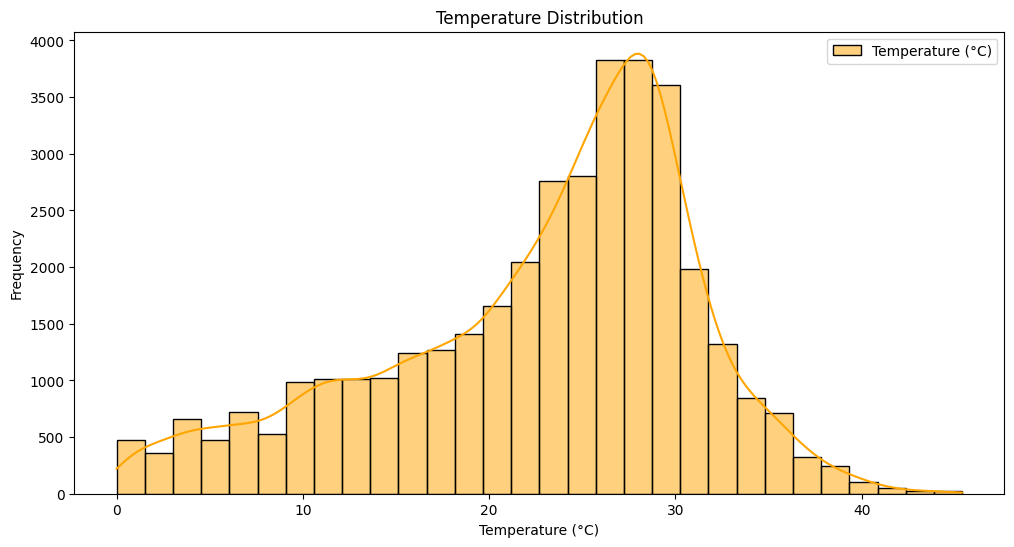

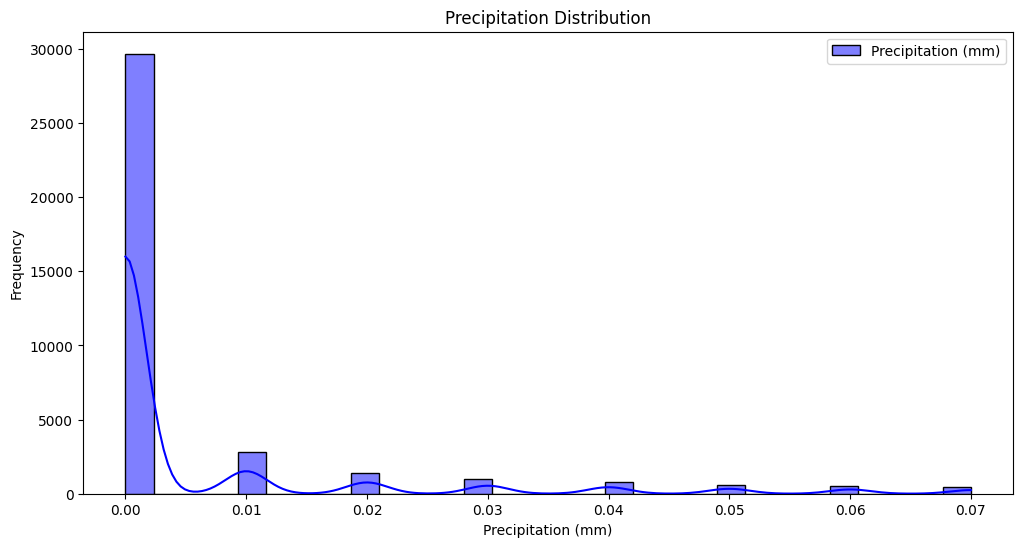

In [35]:
# Distribution of Temperature & Precipitation
plt.figure(figsize=(12, 6))
sns.histplot(df_cleaned['temperature_celsius'], bins=30, kde=True, color='orange', label='Temperature (°C)')
plt.title('Temperature Distribution')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df_cleaned['precip_mm'], bins=30, kde=True, color='blue', label='Precipitation (mm)')
plt.title('Precipitation Distribution')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


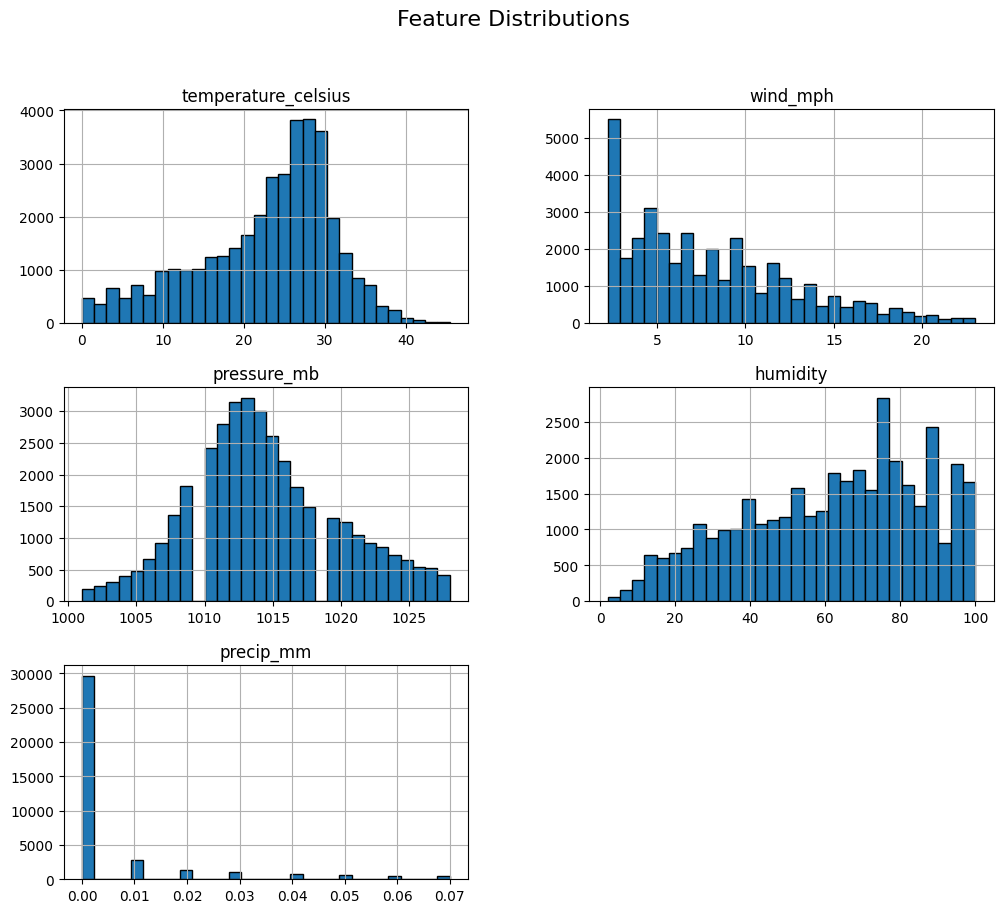

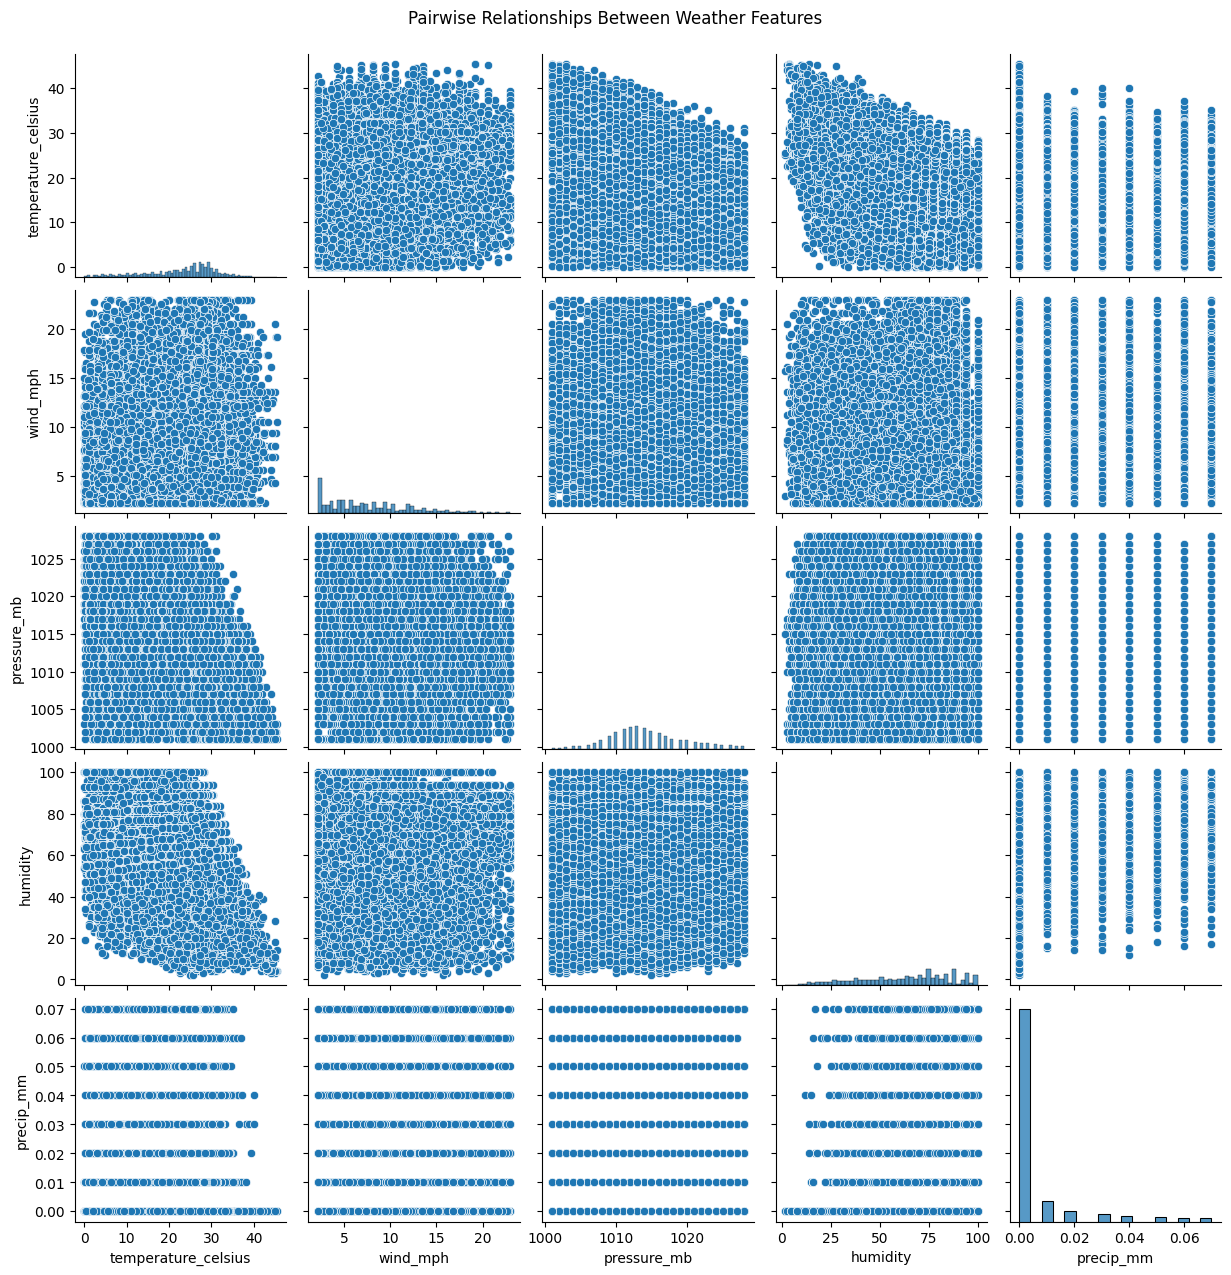

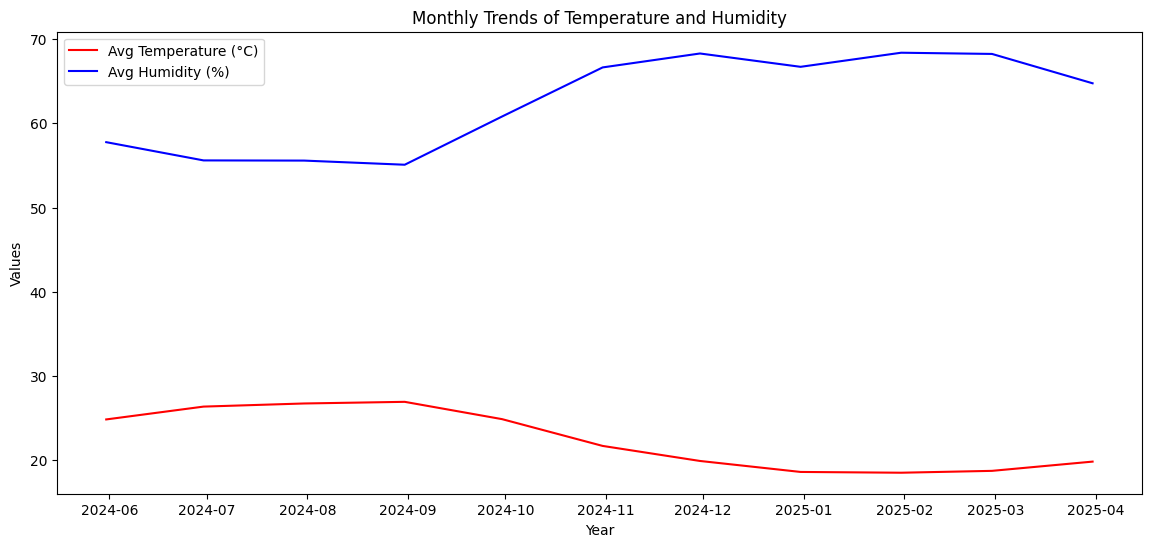

In [36]:
# Feature distributions using histograms (excluding correlation heatmap)
features = ['temperature_celsius', 'wind_mph', 'pressure_mb', 'humidity', 'precip_mm']
df_cleaned[features].hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

# Pairplot to analyze relationships between numerical features
sns.pairplot(df_cleaned[features])
plt.suptitle("Pairwise Relationships Between Weather Features", y=1.02)
plt.show()

# Time series trend analysis (if timestamp exists and is not already analyzed)
if 'last_updated' in df_cleaned.columns:
    df_cleaned['last_updated'] = pd.to_datetime(df_cleaned['last_updated'], errors='coerce')
    df_cleaned.set_index('last_updated', inplace=True)

    # Resampling monthly means for smoother trend analysis
    df_monthly = df_cleaned[features].resample('M').mean()

    plt.figure(figsize=(14,6))
    plt.plot(df_monthly.index, df_monthly['temperature_celsius'], label="Avg Temperature (°C)", color='red')
    plt.plot(df_monthly.index, df_monthly['humidity'], label="Avg Humidity (%)", color='blue')
    plt.xlabel("Year")
    plt.ylabel("Values")
    plt.title("Monthly Trends of Temperature and Humidity")
    plt.legend()
    plt.show()



Number of detected anomalies: 1866


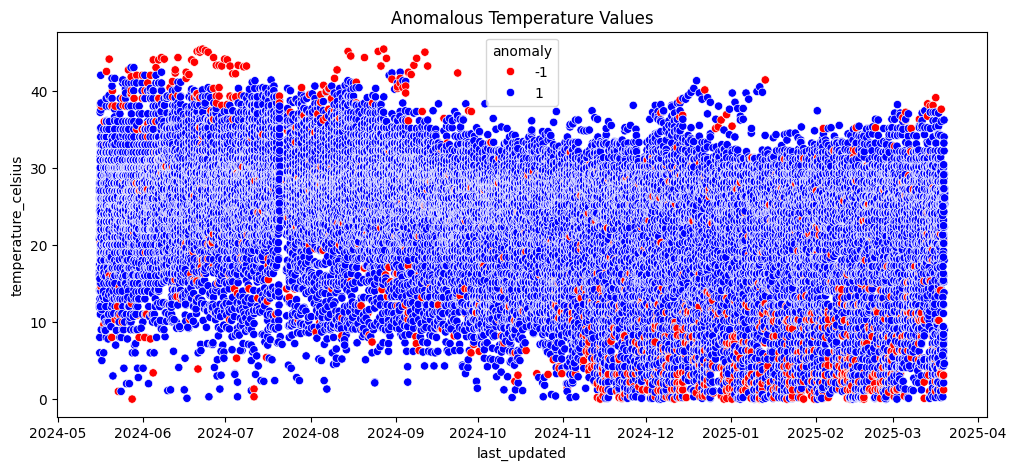

In [37]:
# Select relevant features for anomaly detection
features = ['temperature_celsius', 'humidity', 'wind_mph', 'pressure_mb', 'precip_mm', 'air_quality_PM2.5']

# Initialize Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # Adjust contamination level
df_cleaned['anomaly'] = iso_forest.fit_predict(df_cleaned[features])

# Mark anomalies: -1 for anomalies, 1 for normal data
df_anomalies = df_cleaned[df_cleaned['anomaly'] == -1]
print(f"\nNumber of detected anomalies: {df_anomalies.shape[0]}")

# Visualize Anomalies
plt.figure(figsize=(12,5))
sns.scatterplot(x=df_cleaned.index, y=df_cleaned['temperature_celsius'], hue=df_cleaned['anomaly'], palette={1:'blue', -1:'red'})
plt.title("Anomalous Temperature Values")
plt.show()


(11, 31)


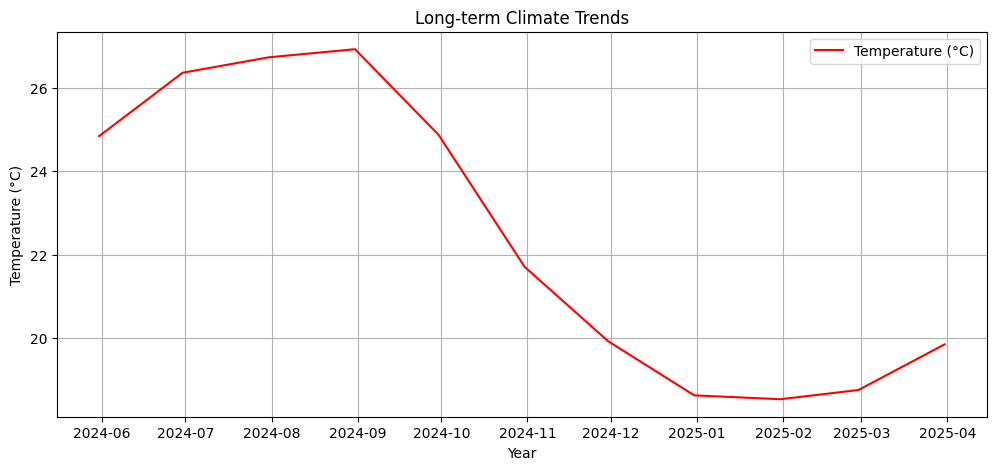

In [38]:
# Ensure index is datetime type
if not isinstance(df_cleaned.index, pd.DatetimeIndex):
    df_cleaned.index = pd.to_datetime(df_cleaned.index, errors='coerce')

# Select only numeric columns for resampling
numeric_cols = df_cleaned.select_dtypes(include=[np.number])

# Resample monthly and compute mean only for numeric columns
df_climate_trends = numeric_cols.resample('M').mean()

print(df_climate_trends.shape)  # See if data exists after resampling

# Ensure data exists before plotting
if not df_climate_trends.empty and 'temperature_celsius' in df_climate_trends.columns:
    plt.figure(figsize=(12, 5))
    plt.plot(df_climate_trends.index, df_climate_trends['temperature_celsius'], label="Temperature (°C)", color='red')
    plt.xlabel("Year")
    plt.ylabel("Temperature (°C)")
    plt.title("Long-term Climate Trends")
    plt.legend()
    plt.grid(True)
    plt.show()


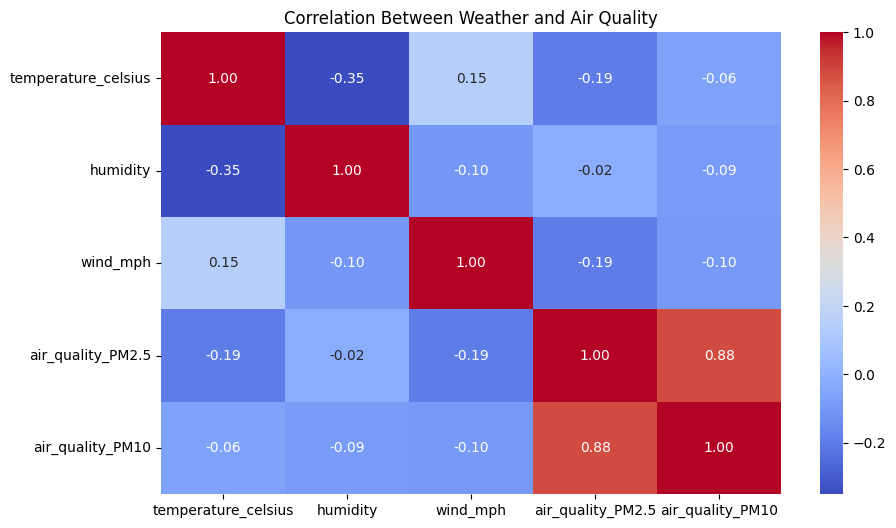

In [39]:
# Correlation matrix
plt.figure(figsize=(10,6))
sns.heatmap(df_cleaned[['temperature_celsius', 'humidity', 'wind_mph', 'air_quality_PM2.5', 'air_quality_PM10']].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Weather and Air Quality")
plt.show()

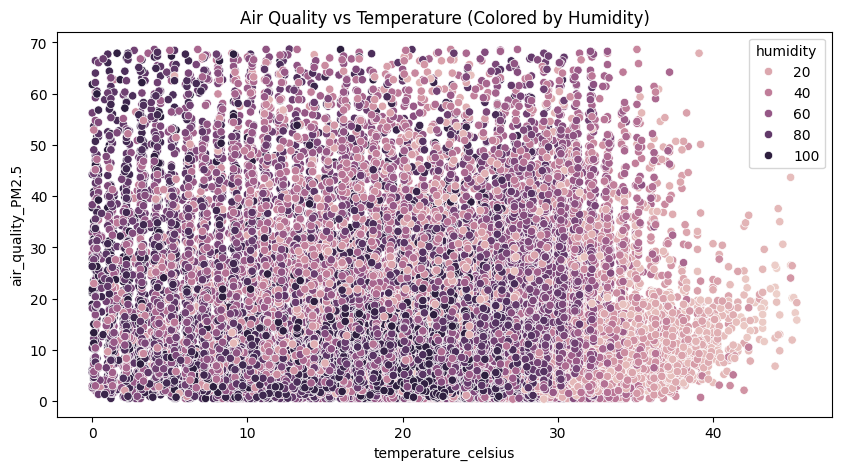

In [40]:
# Scatter plot: Temperature vs. Air Quality
plt.figure(figsize=(10,5))
sns.scatterplot(x=df_cleaned['temperature_celsius'], y=df_cleaned['air_quality_PM2.5'], hue=df_cleaned['humidity'])
plt.title("Air Quality vs Temperature (Colored by Humidity)")
plt.show()

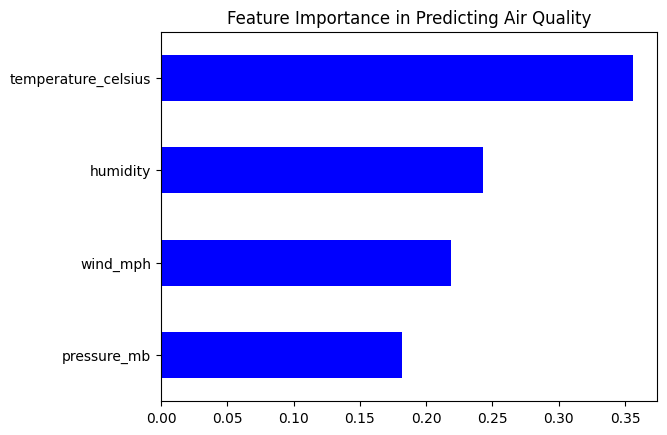

In [41]:

# Select features and target
features = ['temperature_celsius', 'humidity', 'wind_mph', 'pressure_mb']
X = df_cleaned[features]
y = df_cleaned['air_quality_PM2.5']

# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Get feature importance
feature_importance = pd.Series(rf_model.feature_importances_, index=features)

# Plot feature importance
feature_importance.sort_values().plot(kind='barh', color='blue')
plt.title("Feature Importance in Predicting Air Quality")
plt.show()


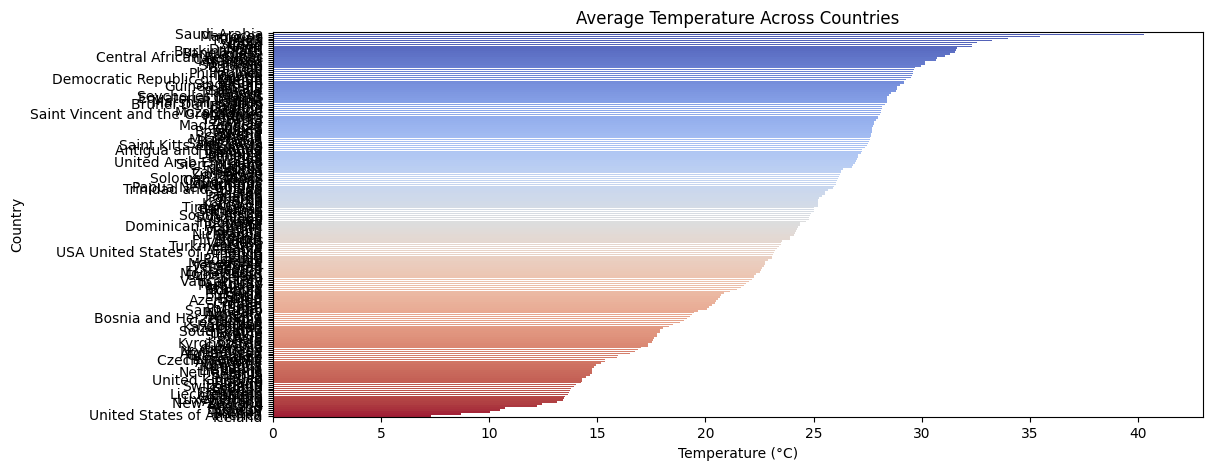

In [42]:
# Group by country and calculate mean temperature & air quality
country_weather = df_cleaned.groupby('country')[['temperature_celsius', 'air_quality_PM2.5']].mean().reset_index()

# Sort by temperature
country_weather = country_weather.sort_values(by='temperature_celsius', ascending=False)

# Plot temperature distribution by country
plt.figure(figsize=(12,5))
sns.barplot(y=country_weather['country'], x=country_weather['temperature_celsius'], palette='coolwarm')
plt.title("Average Temperature Across Countries")
plt.xlabel("Temperature (°C)")
plt.ylabel("Country")
plt.show()
